In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.checkpoint import checkpoint
from transformers import AutoConfig
from transformers import AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding

In [4]:
# Configurations
class CFG:
    SEED = 0
    TRAIN_DATA_PATH = Path('../../radnlp_2024_train_val_20240731/ja/main_task/train')
    VALID_DATA_PATH = Path('../../radnlp_2024_train_val_20240731/ja/main_task/val')
    MODEL_SAVE_PATH = Path('./model')
    MODEL_NAME = 'debarta'
    MODEL_PATH = 'microsoft/deberta-v3-large'
    # MODEL_NAME = 'globis-university/deberta-v3-japanese-large'
    # MODEL_PATH = 'globis-university/deberta-v3-japanese-large'
    MAX_LENGTH = 512
    INPUT_COL = 'text'
    TARGET_COL1, TARGET_CLASS_NUM1 = 't', 10
    TARGET_COL2, TARGET_CLASS_NUM2 = 'n', 4
    TARGET_COL3, TARGET_CLASS_NUM3 = 'm', 4
    EPOCHS = 30
    LEARNING_RATE = 1e-5
    BATCH_SIZE = 5
    STEPS = 10
    METRIC = 'accuracy'
    metric_maximize_flag = True

In [5]:
def get_device() -> str:
    """
    Returns the best available device for PyTorch computations.
    """
    if torch.backends.mps.is_available():
        # macOS with Apple Silicon (MPS backend)
        return "mps"
    elif torch.cuda.is_available():
        # NVIDIA GPU
        return "cuda"
    else:
        # Fallback to CPU
        return "cpu"

try:
    device = torch.device(get_device())
    print(f"Using device: {device}")
except RuntimeError as e:
    print(f"Failed to initialize the device: {e}")
    device = torch.device("cpu")  # Fallback to CPU in case of an error

Using device: cuda


In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False #Trueで高速化重視, Falseで再現性重視
seed_everything(CFG.SEED)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.set_num_threads(1)

In [7]:
def create_dataframe(folder_path):
    """
    指定されたフォルダ内のテキストファイルからDataFrameを作成する関数

    Args:
        folder_path (PosixPath): テキストファイルが入っているフォルダのパス

    Returns:
        pandas.DataFrame: 作成されたDataFrame
    """

    # フォルダ内のすべてのテキストファイルのパスを取得
    file_list = list(folder_path.glob('*.txt'))

    # 空のDataFrameを作成
    df_text = pd.DataFrame(columns=['id', 'text'])
    
    # label.csvを読み込む
    df_label = pd.read_csv(os.path.join(folder_path, "label.csv"))

    for file in file_list:
        # ファイル名からIDを抽出
        # file_id = str(file).split("/")[-1].split(".")[0]
        file_id = str(file).split("\\")[-1].split(".")[0] # Windows
        
        # テキストファイルを読み込む
        with open(file, 'r', encoding='utf-8') as f:
            text = f.read()

        # DataFrameに追記
        rows = []
        rows.append({'id': int(file_id), 'text': text})
        df_text = pd.concat([df_text, pd.DataFrame(rows)], ignore_index=True)
        
    # textとlabelのDataFrameを結合
    df = pd.merge(df_text, df_label, on='id', how='left')

    return df

train_df = create_dataframe(CFG.TRAIN_DATA_PATH)
val_df = create_dataframe(CFG.VALID_DATA_PATH)

In [8]:
train_df.head(n=10)

,id,text,t,n,m
0,10223615,右肺下葉 S8 末梢側の胸膜下領域に約 3cm の分葉状不整形腫瘤性病変を認めます。主体は充...,T1c,N0,M0
1,10320785,右肺門部から縦隔内に多発性の腫瘤を認めます。既知の小細胞癌とその転移と考え\nます。原発のサ...,T3,N2,M0
2,10405379,右主気管支内には⻑径 17mm 大の結節影があり、既知の粘表皮癌部分と思われます。右下葉枝は...,T2a,N0,M0
3,11013624,左上葉に 12cm の巨大な低吸収腫瘤があります。\n肺癌と考えます。\n縦隔側の胸膜と広...,T4,N2,M0
4,11044030,縦隔には累々としたリンパ節腫大が認められ、既知のリンパ節病変と思われます。右上葉には小結節を...,T0,N2,M0
5,11079957,左肺下葉 S10 中心に約 72mm の充実性腫瘤性病変を認めます。原発性肺癌を疑います。胸...,T4,N0,M1c
6,11117507,右肺尖部に spicula を伴う 50mm の腫瘤性病変があります。\n胸膜と広く接し...,T2b,N0,M0
7,11328933,冠状断再構成画像において右肺下葉に mixed GGO を認めます。既知の肺癌を疑いま\nす...,T1c,N0,M0
8,11595888,右肺尖部に胸膜に接する 50mm 大の腫瘤を認めます。辺縁不整でスピクラ様の毛羽\n立ちを認...,T3,N0,M0
9,11604112,肺野背景に気腫性変化を認めます。\n右肺尖部に辺縁不整な腫瘤を認めます。既知の癌病変と考えま...,T2b,N2,M1b


In [9]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, class_list, tokenizer, max_length, text_column, label_column):
        """
        Args:
            class_list: 全てのクラスのリスト
            text_column (str): テキストが含まれる列名
            label_column (str): ラベルが含まれる列名
        """
        self.texts = dataframe[text_column].tolist()
        # 特定のクラスのデータが抜けていたり、クラス名がstrの場合はOrdinalEncoderを使う方が無難（LabelEncoderは順番がずれる）
        self.labels = OrdinalEncoder(categories=[class_list]).fit_transform(dataframe[[label_column]]).flatten().astype(int)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        )
        encoding['labels'] = torch.tensor(label, dtype=torch.long)
        return {key: val.squeeze(0) for key, val in encoding.items()}
        """
        Returns: dict
            "input_ids": tensor([...]),
            "attention_mask": tensor([...]),
            "labels": tensor(label)
        """

class_list_t = ['T0','Tis','T1mi','T1a','T1b','T1c','T2a','T2b','T3','T4']
class_list_n = ['N0','N1','N2','N3']
class_list_m = ['M0','M1a','M1b','M1c']


In [10]:
tokenizer = AutoTokenizer.from_pretrained(CFG.MODEL_PATH)

train_dataset_t = CustomDataset(train_df, class_list_t, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL1)
val_dataset_t = CustomDataset(val_df, class_list_t, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL1)
train_dataset_n = CustomDataset(train_df, class_list_n, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL2)
val_dataset_n = CustomDataset(val_df, class_list_n, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL2)
train_dataset_m = CustomDataset(train_df, class_list_m, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL3)
val_dataset_m = CustomDataset(val_df, class_list_m, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL3)

In [11]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).to('cpu').numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [12]:
class CheckpointingDeberta(AutoModelForSequenceClassification):
    def forward(self, *args, **kwargs):
        # `checkpoint` を使ってメモリを節約
        return checkpoint(super().forward, *args, **kwargs)

In [13]:
def plot_loss(train_loss):
    plt.plot(train_loss)
    plt.xlabel('step')
    plt.ylabel('loss')
    plt.legend(['train_loss'], loc='upper right')
    plt.xticks(np.arange(0, len(train_loss) + 1, 5))
    plt.show()

def plot_metrics(valid_acc):
    plt.plot(valid_acc)
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['valid_acc'], loc='lower right')
    plt.xticks(np.arange(0, len(valid_acc) + 1, 5))
    plt.show()

# T分類の学習

In [14]:
training_args = TrainingArguments(
    do_eval=True,
    evaluation_strategy="epoch",
    learning_rate=CFG.LEARNING_RATE,
    lr_scheduler_type='linear',
    per_device_train_batch_size=CFG.BATCH_SIZE,
    per_device_eval_batch_size=CFG.BATCH_SIZE,
    gradient_accumulation_steps=2, # 勾配の累積ステップ数。メモリ不足の場合は増やす。
    num_train_epochs=CFG.EPOCHS,
    weight_decay=0.01, # 正則化
    fp16=False, # 高速化. NVIDIA GPUのみ
    logging_dir= Path('./logs_t'),
    logging_steps=CFG.STEPS,
    save_strategy="epoch",
    output_dir=CFG.MODEL_SAVE_PATH / 't',
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model=CFG.METRIC,
    greater_is_better=True,
    save_safetensors=True, # モデルの保存形式
    push_to_hub=False,
    seed=CFG.SEED,
    data_seed=CFG.SEED,
)

In [15]:
config = AutoConfig.from_pretrained(CFG.MODEL_PATH)
config.num_labels=CFG.TARGET_CLASS_NUM1
model = AutoModelForSequenceClassification.from_pretrained(CFG.MODEL_PATH, config=config)
model.classifier

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1024, out_features=10, bias=True)

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_t,
    eval_dataset=val_dataset_t,
    data_collator=DataCollatorWithPadding(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/330 [00:00<?, ?it/s]

{'loss': 4.5722, 'grad_norm': 8.812246322631836, 'learning_rate': 9.696969696969698e-06, 'epoch': 0.91}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.227102041244507, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.16666666666666666, 'eval_precision': 0.1111111111111111, 'eval_recall': 0.3333333333333333, 'eval_runtime': 1.4153, 'eval_samples_per_second': 38.154, 'eval_steps_per_second': 7.772, 'epoch': 1.0}
{'loss': 4.1688, 'grad_norm': 18.817611694335938, 'learning_rate': 9.393939393939396e-06, 'epoch': 1.82}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.1153228282928467, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.16666666666666666, 'eval_precision': 0.1111111111111111, 'eval_recall': 0.3333333333333333, 'eval_runtime': 1.4303, 'eval_samples_per_second': 37.754, 'eval_steps_per_second': 7.691, 'epoch': 2.0}
{'loss': 3.8526, 'grad_norm': 12.875777244567871, 'learning_rate': 9.090909090909091e-06, 'epoch': 2.73}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.1406660079956055, 'eval_accuracy': 0.3148148148148148, 'eval_f1': 0.16190476190476188, 'eval_precision': 0.10897435897435898, 'eval_recall': 0.3148148148148148, 'eval_runtime': 1.4143, 'eval_samples_per_second': 38.181, 'eval_steps_per_second': 7.778, 'epoch': 3.0}
{'loss': 3.6966, 'grad_norm': 13.368341445922852, 'learning_rate': 8.787878787878788e-06, 'epoch': 3.64}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.125336170196533, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.16666666666666666, 'eval_precision': 0.1111111111111111, 'eval_recall': 0.3333333333333333, 'eval_runtime': 1.4263, 'eval_samples_per_second': 37.86, 'eval_steps_per_second': 7.712, 'epoch': 4.0}
{'loss': 3.6647, 'grad_norm': 13.37460994720459, 'learning_rate': 8.484848484848486e-06, 'epoch': 4.55}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.1489903926849365, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.16666666666666666, 'eval_precision': 0.1111111111111111, 'eval_recall': 0.3333333333333333, 'eval_runtime': 1.4733, 'eval_samples_per_second': 36.652, 'eval_steps_per_second': 7.466, 'epoch': 5.0}
{'loss': 3.4921, 'grad_norm': 13.974921226501465, 'learning_rate': 8.181818181818183e-06, 'epoch': 5.45}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.0854809284210205, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.17391304347826086, 'eval_precision': 0.11764705882352942, 'eval_recall': 0.3333333333333333, 'eval_runtime': 1.3803, 'eval_samples_per_second': 39.122, 'eval_steps_per_second': 7.969, 'epoch': 6.0}
{'loss': 3.3312, 'grad_norm': 13.433446884155273, 'learning_rate': 7.87878787878788e-06, 'epoch': 6.36}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.0968313217163086, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.19354838709677422, 'eval_precision': 0.13636363636363638, 'eval_recall': 0.3333333333333333, 'eval_runtime': 1.3653, 'eval_samples_per_second': 39.552, 'eval_steps_per_second': 8.057, 'epoch': 7.0}
{'loss': 3.0903, 'grad_norm': 14.869325637817383, 'learning_rate': 7.5757575757575764e-06, 'epoch': 7.27}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.1806716918945312, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.19047619047619047, 'eval_precision': 0.13333333333333333, 'eval_recall': 0.3333333333333333, 'eval_runtime': 1.3693, 'eval_samples_per_second': 39.436, 'eval_steps_per_second': 8.033, 'epoch': 8.0}
{'loss': 3.0076, 'grad_norm': 18.535606384277344, 'learning_rate': 7.272727272727273e-06, 'epoch': 8.18}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.3014235496520996, 'eval_accuracy': 0.37037037037037035, 'eval_f1': 0.2543290043290043, 'eval_precision': 0.19912280701754387, 'eval_recall': 0.37037037037037035, 'eval_runtime': 1.3743, 'eval_samples_per_second': 39.293, 'eval_steps_per_second': 8.004, 'epoch': 9.0}
{'loss': 2.5091, 'grad_norm': 24.168581008911133, 'learning_rate': 6.969696969696971e-06, 'epoch': 9.09}
{'loss': 2.3225, 'grad_norm': 64.36675262451172, 'learning_rate': 6.666666666666667e-06, 'epoch': 10.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.3387491703033447, 'eval_accuracy': 0.37037037037037035, 'eval_f1': 0.24826162538026947, 'eval_precision': 0.2177700348432056, 'eval_recall': 0.37037037037037035, 'eval_runtime': 1.3673, 'eval_samples_per_second': 39.494, 'eval_steps_per_second': 8.045, 'epoch': 10.0}
{'loss': 2.0502, 'grad_norm': 24.25250244140625, 'learning_rate': 6.363636363636364e-06, 'epoch': 10.91}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.3432343006134033, 'eval_accuracy': 0.35185185185185186, 'eval_f1': 0.2596119929453263, 'eval_precision': 0.2060931899641577, 'eval_recall': 0.35185185185185186, 'eval_runtime': 1.3823, 'eval_samples_per_second': 39.065, 'eval_steps_per_second': 7.958, 'epoch': 11.0}
{'loss': 1.7374, 'grad_norm': 18.6532039642334, 'learning_rate': 6.060606060606061e-06, 'epoch': 11.82}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.366241693496704, 'eval_accuracy': 0.2962962962962963, 'eval_f1': 0.23086009597637508, 'eval_precision': 0.19380471380471379, 'eval_recall': 0.2962962962962963, 'eval_runtime': 1.3813, 'eval_samples_per_second': 39.093, 'eval_steps_per_second': 7.963, 'epoch': 12.0}
{'loss': 1.6313, 'grad_norm': 20.924903869628906, 'learning_rate': 5.7575757575757586e-06, 'epoch': 12.73}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.4907591342926025, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.24688644688644687, 'eval_precision': 0.19815668202764977, 'eval_recall': 0.3333333333333333, 'eval_runtime': 1.4333, 'eval_samples_per_second': 37.675, 'eval_steps_per_second': 7.675, 'epoch': 13.0}
{'loss': 1.4272, 'grad_norm': 13.400741577148438, 'learning_rate': 5.4545454545454545e-06, 'epoch': 13.64}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.387377977371216, 'eval_accuracy': 0.35185185185185186, 'eval_f1': 0.2830439134786961, 'eval_precision': 0.25555173336391085, 'eval_recall': 0.35185185185185186, 'eval_runtime': 1.4213, 'eval_samples_per_second': 37.993, 'eval_steps_per_second': 7.739, 'epoch': 14.0}
{'loss': 1.0985, 'grad_norm': 9.971379280090332, 'learning_rate': 5.151515151515152e-06, 'epoch': 14.55}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.4500887393951416, 'eval_accuracy': 0.2962962962962963, 'eval_f1': 0.2439360929557008, 'eval_precision': 0.21765271765271765, 'eval_recall': 0.2962962962962963, 'eval_runtime': 1.5104, 'eval_samples_per_second': 35.753, 'eval_steps_per_second': 7.283, 'epoch': 15.0}
{'loss': 0.9718, 'grad_norm': 11.585139274597168, 'learning_rate': 4.848484848484849e-06, 'epoch': 15.45}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.5025696754455566, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.2732276135784908, 'eval_precision': 0.24859691964955122, 'eval_recall': 0.3333333333333333, 'eval_runtime': 1.4353, 'eval_samples_per_second': 37.622, 'eval_steps_per_second': 7.664, 'epoch': 16.0}
{'loss': 0.7543, 'grad_norm': 10.20324420928955, 'learning_rate': 4.5454545454545455e-06, 'epoch': 16.36}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.654057741165161, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.27253733920400586, 'eval_precision': 0.2521825396825397, 'eval_recall': 0.3333333333333333, 'eval_runtime': 1.4523, 'eval_samples_per_second': 37.182, 'eval_steps_per_second': 7.574, 'epoch': 17.0}
{'loss': 0.708, 'grad_norm': 8.405442237854004, 'learning_rate': 4.242424242424243e-06, 'epoch': 17.27}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.886018991470337, 'eval_accuracy': 0.25925925925925924, 'eval_f1': 0.23580201474938317, 'eval_precision': 0.2428849902534113, 'eval_recall': 0.25925925925925924, 'eval_runtime': 1.4673, 'eval_samples_per_second': 36.802, 'eval_steps_per_second': 7.497, 'epoch': 18.0}
{'loss': 0.4725, 'grad_norm': 14.438081741333008, 'learning_rate': 3.93939393939394e-06, 'epoch': 18.18}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.673842191696167, 'eval_accuracy': 0.3148148148148148, 'eval_f1': 0.2574491785018101, 'eval_precision': 0.23333333333333334, 'eval_recall': 0.3148148148148148, 'eval_runtime': 1.4683, 'eval_samples_per_second': 36.777, 'eval_steps_per_second': 7.492, 'epoch': 19.0}
{'loss': 0.5376, 'grad_norm': 10.21487808227539, 'learning_rate': 3.6363636363636366e-06, 'epoch': 19.09}
{'loss': 0.3515, 'grad_norm': 12.385880470275879, 'learning_rate': 3.3333333333333333e-06, 'epoch': 20.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.7043323516845703, 'eval_accuracy': 0.3148148148148148, 'eval_f1': 0.2703131860837954, 'eval_precision': 0.28685388685388685, 'eval_recall': 0.3148148148148148, 'eval_runtime': 1.4073, 'eval_samples_per_second': 38.371, 'eval_steps_per_second': 7.816, 'epoch': 20.0}
{'loss': 0.3623, 'grad_norm': 6.017962455749512, 'learning_rate': 3.0303030303030305e-06, 'epoch': 20.91}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.738593816757202, 'eval_accuracy': 0.37037037037037035, 'eval_f1': 0.32463511720477667, 'eval_precision': 0.30791245791245786, 'eval_recall': 0.37037037037037035, 'eval_runtime': 1.4633, 'eval_samples_per_second': 36.902, 'eval_steps_per_second': 7.517, 'epoch': 21.0}
{'loss': 0.3016, 'grad_norm': 12.57752513885498, 'learning_rate': 2.7272727272727272e-06, 'epoch': 21.82}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.824913501739502, 'eval_accuracy': 0.3888888888888889, 'eval_f1': 0.30841228825724953, 'eval_precision': 0.2607407407407408, 'eval_recall': 0.3888888888888889, 'eval_runtime': 1.4923, 'eval_samples_per_second': 36.185, 'eval_steps_per_second': 7.371, 'epoch': 22.0}
{'loss': 0.1627, 'grad_norm': 2.985928773880005, 'learning_rate': 2.4242424242424244e-06, 'epoch': 22.73}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.8552637100219727, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.2703173369840036, 'eval_precision': 0.23928571428571427, 'eval_recall': 0.3333333333333333, 'eval_runtime': 1.5063, 'eval_samples_per_second': 35.849, 'eval_steps_per_second': 7.303, 'epoch': 23.0}
{'loss': 0.3438, 'grad_norm': 4.257930278778076, 'learning_rate': 2.1212121212121216e-06, 'epoch': 23.64}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.9797489643096924, 'eval_accuracy': 0.37037037037037035, 'eval_f1': 0.29651907546644385, 'eval_precision': 0.255307963641297, 'eval_recall': 0.37037037037037035, 'eval_runtime': 1.5173, 'eval_samples_per_second': 35.589, 'eval_steps_per_second': 7.25, 'epoch': 24.0}
{'loss': 0.2407, 'grad_norm': 3.7498648166656494, 'learning_rate': 1.8181818181818183e-06, 'epoch': 24.55}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.0172739028930664, 'eval_accuracy': 0.35185185185185186, 'eval_f1': 0.2848484848484848, 'eval_precision': 0.24927849927849924, 'eval_recall': 0.35185185185185186, 'eval_runtime': 1.4823, 'eval_samples_per_second': 36.429, 'eval_steps_per_second': 7.421, 'epoch': 25.0}
{'loss': 0.1765, 'grad_norm': 13.94511890411377, 'learning_rate': 1.5151515151515152e-06, 'epoch': 25.45}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.025341749191284, 'eval_accuracy': 0.37037037037037035, 'eval_f1': 0.305942305942306, 'eval_precision': 0.27863060428849906, 'eval_recall': 0.37037037037037035, 'eval_runtime': 1.5113, 'eval_samples_per_second': 35.73, 'eval_steps_per_second': 7.278, 'epoch': 26.0}
{'loss': 0.1364, 'grad_norm': 2.4642441272735596, 'learning_rate': 1.2121212121212122e-06, 'epoch': 26.36}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.0811634063720703, 'eval_accuracy': 0.35185185185185186, 'eval_f1': 0.28439955106621767, 'eval_precision': 0.2486171236171236, 'eval_recall': 0.35185185185185186, 'eval_runtime': 1.5143, 'eval_samples_per_second': 35.659, 'eval_steps_per_second': 7.264, 'epoch': 27.0}
{'loss': 0.1704, 'grad_norm': 1.422532320022583, 'learning_rate': 9.090909090909091e-07, 'epoch': 27.27}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.1448771953582764, 'eval_accuracy': 0.35185185185185186, 'eval_f1': 0.29837642386662, 'eval_precision': 0.2919973544973545, 'eval_recall': 0.35185185185185186, 'eval_runtime': 1.5043, 'eval_samples_per_second': 35.896, 'eval_steps_per_second': 7.312, 'epoch': 28.0}
{'loss': 0.2284, 'grad_norm': 10.010204315185547, 'learning_rate': 6.060606060606061e-07, 'epoch': 28.18}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.113555669784546, 'eval_accuracy': 0.35185185185185186, 'eval_f1': 0.29392336059002727, 'eval_precision': 0.27997895064458533, 'eval_recall': 0.35185185185185186, 'eval_runtime': 1.5129, 'eval_samples_per_second': 35.693, 'eval_steps_per_second': 7.271, 'epoch': 29.0}
{'loss': 0.1286, 'grad_norm': 1.5554313659667969, 'learning_rate': 3.0303030303030305e-07, 'epoch': 29.09}
{'loss': 0.1635, 'grad_norm': 1.7645282745361328, 'learning_rate': 0.0, 'epoch': 30.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.1093332767486572, 'eval_accuracy': 0.35185185185185186, 'eval_f1': 0.29392336059002727, 'eval_precision': 0.27997895064458533, 'eval_recall': 0.35185185185185186, 'eval_runtime': 1.4213, 'eval_samples_per_second': 37.993, 'eval_steps_per_second': 7.739, 'epoch': 30.0}
{'train_runtime': 504.8215, 'train_samples_per_second': 6.418, 'train_steps_per_second': 0.654, 'train_loss': 1.571609255400571, 'epoch': 30.0}


TrainOutput(global_step=330, training_loss=1.571609255400571, metrics={'train_runtime': 504.8215, 'train_samples_per_second': 6.418, 'train_steps_per_second': 0.654, 'total_flos': 1693580356571712.0, 'train_loss': 1.571609255400571, 'epoch': 30.0})

In [17]:
train_loss, eval_acc = [],[]

for log in trainer.state.log_history:
    if 'loss' in log:
         train_loss.append(log['loss'])
    if 'eval_accuracy' in log:
        eval_acc.append(log['eval_accuracy'])


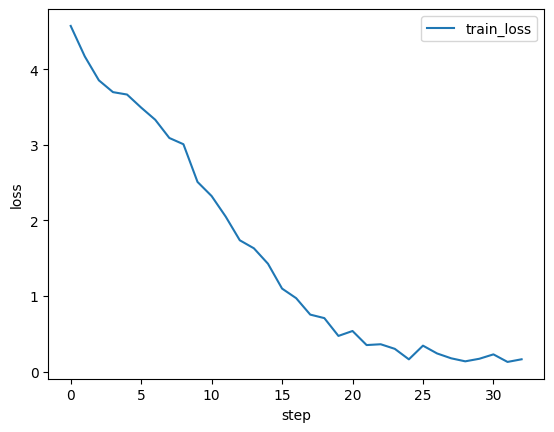

In [18]:
plot_loss(train_loss)

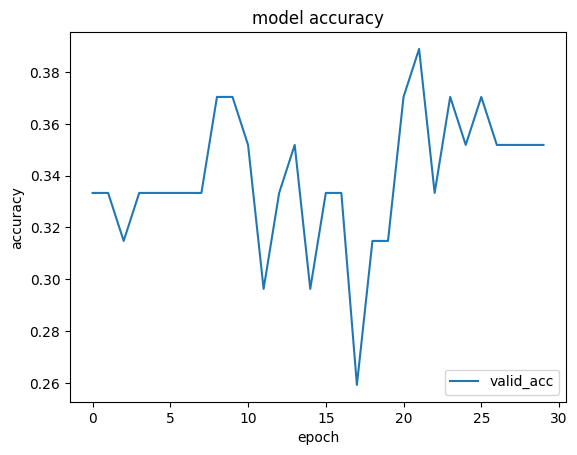

In [19]:
plot_metrics(eval_acc)

In [20]:
base_folder = CFG.MODEL_SAVE_PATH / 't'
trained_model_path = [f for f in base_folder.iterdir() if f.is_dir() and "checkpoint-" in f.name][0]
trained_model = AutoModelForSequenceClassification.from_pretrained(trained_model_path)

In [21]:
trainer = Trainer(
    model=trained_model,
    args=training_args,
    train_dataset=train_dataset_t,
    eval_dataset=val_dataset_t,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

predictions = torch.softmax(torch.tensor(trainer.predict(val_dataset_t).predictions), dim = 1).argmax(axis=1).tolist()
labels = [val_dataset_t[i]["labels"].item() for i in range(len(val_dataset_t))]
print(accuracy_score(labels, predictions))


  0%|          | 0/11 [00:00<?, ?it/s]

0.3888888888888889


# N分類の学習

In [22]:
training_args = TrainingArguments(
    do_eval=True,
    evaluation_strategy="epoch",
    learning_rate=CFG.LEARNING_RATE,
    lr_scheduler_type='linear',
    per_device_train_batch_size=CFG.BATCH_SIZE,
    per_device_eval_batch_size=CFG.BATCH_SIZE,
    gradient_accumulation_steps=1, # 勾配の累積ステップ数。メモリ不足の場合は増やす。
    num_train_epochs=CFG.EPOCHS,
    weight_decay=0.01, # 正則化
    fp16=False, # 高速化. NVIDIA GPUのみ
    logging_dir= Path('./logs_n'),
    logging_steps=CFG.STEPS,
    save_strategy="epoch",
    output_dir=CFG.MODEL_SAVE_PATH / 'n',
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model=CFG.METRIC,
    greater_is_better=True,
    save_safetensors=True, # モデルの保存形式
    push_to_hub=False,
    seed=CFG.SEED,
    data_seed=CFG.SEED,
)

In [23]:
config = AutoConfig.from_pretrained(CFG.MODEL_PATH)
config.num_labels=CFG.TARGET_CLASS_NUM2
model = AutoModelForSequenceClassification.from_pretrained(CFG.MODEL_PATH, config=config)
model.classifier

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1024, out_features=4, bias=True)

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_n,
    eval_dataset=val_dataset_n,
    data_collator=DataCollatorWithPadding(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/660 [00:00<?, ?it/s]

{'loss': 1.4067, 'grad_norm': 3.4739441871643066, 'learning_rate': 9.84848484848485e-06, 'epoch': 0.45}
{'loss': 1.3219, 'grad_norm': 6.356015205383301, 'learning_rate': 9.696969696969698e-06, 'epoch': 0.91}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.2945581674575806, 'eval_accuracy': 0.37037037037037035, 'eval_f1': 0.20020020020020018, 'eval_precision': 0.1371742112482853, 'eval_recall': 0.37037037037037035, 'eval_runtime': 1.4733, 'eval_samples_per_second': 36.652, 'eval_steps_per_second': 7.466, 'epoch': 1.0}
{'loss': 1.2678, 'grad_norm': 8.442695617675781, 'learning_rate': 9.545454545454547e-06, 'epoch': 1.36}
{'loss': 1.1848, 'grad_norm': 10.640704154968262, 'learning_rate': 9.393939393939396e-06, 'epoch': 1.82}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.249812126159668, 'eval_accuracy': 0.37037037037037035, 'eval_f1': 0.20020020020020018, 'eval_precision': 0.1371742112482853, 'eval_recall': 0.37037037037037035, 'eval_runtime': 1.5023, 'eval_samples_per_second': 35.944, 'eval_steps_per_second': 7.322, 'epoch': 2.0}
{'loss': 1.3217, 'grad_norm': 5.613352298736572, 'learning_rate': 9.242424242424244e-06, 'epoch': 2.27}
{'loss': 1.2462, 'grad_norm': 3.4931015968322754, 'learning_rate': 9.090909090909091e-06, 'epoch': 2.73}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.1770371198654175, 'eval_accuracy': 0.37037037037037035, 'eval_f1': 0.20020020020020018, 'eval_precision': 0.1371742112482853, 'eval_recall': 0.37037037037037035, 'eval_runtime': 1.52, 'eval_samples_per_second': 35.526, 'eval_steps_per_second': 7.237, 'epoch': 3.0}
{'loss': 1.1488, 'grad_norm': 4.43389892578125, 'learning_rate': 8.93939393939394e-06, 'epoch': 3.18}
{'loss': 1.2462, 'grad_norm': 6.1148576736450195, 'learning_rate': 8.787878787878788e-06, 'epoch': 3.64}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.1699992418289185, 'eval_accuracy': 0.37037037037037035, 'eval_f1': 0.20020020020020018, 'eval_precision': 0.1371742112482853, 'eval_recall': 0.37037037037037035, 'eval_runtime': 1.5113, 'eval_samples_per_second': 35.73, 'eval_steps_per_second': 7.278, 'epoch': 4.0}
{'loss': 1.2634, 'grad_norm': 5.794708728790283, 'learning_rate': 8.636363636363637e-06, 'epoch': 4.09}
{'loss': 1.212, 'grad_norm': 8.693618774414062, 'learning_rate': 8.484848484848486e-06, 'epoch': 4.55}
{'loss': 1.1078, 'grad_norm': 5.77146053314209, 'learning_rate': 8.333333333333334e-06, 'epoch': 5.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.0646692514419556, 'eval_accuracy': 0.7592592592592593, 'eval_f1': 0.7083129548115542, 'eval_precision': 0.6875486987688951, 'eval_recall': 0.7592592592592593, 'eval_runtime': 1.4603, 'eval_samples_per_second': 36.978, 'eval_steps_per_second': 7.533, 'epoch': 5.0}
{'loss': 1.1897, 'grad_norm': 7.387135028839111, 'learning_rate': 8.181818181818183e-06, 'epoch': 5.45}
{'loss': 1.085, 'grad_norm': 7.523983955383301, 'learning_rate': 8.03030303030303e-06, 'epoch': 5.91}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.9062835574150085, 'eval_accuracy': 0.6666666666666666, 'eval_f1': 0.6222708751444385, 'eval_precision': 0.6764132553606238, 'eval_recall': 0.6666666666666666, 'eval_runtime': 1.5153, 'eval_samples_per_second': 35.636, 'eval_steps_per_second': 7.259, 'epoch': 6.0}
{'loss': 0.9214, 'grad_norm': 31.084674835205078, 'learning_rate': 7.87878787878788e-06, 'epoch': 6.36}
{'loss': 1.1282, 'grad_norm': 7.90211296081543, 'learning_rate': 7.727272727272727e-06, 'epoch': 6.82}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.7622838616371155, 'eval_accuracy': 0.7962962962962963, 'eval_f1': 0.732924482924483, 'eval_precision': 0.6790123456790125, 'eval_recall': 0.7962962962962963, 'eval_runtime': 1.5153, 'eval_samples_per_second': 35.636, 'eval_steps_per_second': 7.259, 'epoch': 7.0}
{'loss': 1.0133, 'grad_norm': 12.809171676635742, 'learning_rate': 7.5757575757575764e-06, 'epoch': 7.27}
{'loss': 0.9077, 'grad_norm': 10.414417266845703, 'learning_rate': 7.424242424242425e-06, 'epoch': 7.73}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.5361860990524292, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.7743838276051161, 'eval_precision': 0.7369093231162197, 'eval_recall': 0.8333333333333334, 'eval_runtime': 1.5303, 'eval_samples_per_second': 35.286, 'eval_steps_per_second': 7.188, 'epoch': 8.0}
{'loss': 0.4654, 'grad_norm': 2.479156494140625, 'learning_rate': 7.272727272727273e-06, 'epoch': 8.18}
{'loss': 0.8328, 'grad_norm': 14.461296081542969, 'learning_rate': 7.121212121212122e-06, 'epoch': 8.64}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.560908854007721, 'eval_accuracy': 0.7962962962962963, 'eval_f1': 0.7424895884279638, 'eval_precision': 0.7204301075268817, 'eval_recall': 0.7962962962962963, 'eval_runtime': 1.5113, 'eval_samples_per_second': 35.73, 'eval_steps_per_second': 7.278, 'epoch': 9.0}
{'loss': 0.6675, 'grad_norm': 4.965519905090332, 'learning_rate': 6.969696969696971e-06, 'epoch': 9.09}
{'loss': 0.5391, 'grad_norm': 2.752281665802002, 'learning_rate': 6.818181818181818e-06, 'epoch': 9.55}
{'loss': 0.5329, 'grad_norm': 2.20206880569458, 'learning_rate': 6.666666666666667e-06, 'epoch': 10.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.5550523996353149, 'eval_accuracy': 0.8148148148148148, 'eval_f1': 0.7585185185185185, 'eval_precision': 0.728395061728395, 'eval_recall': 0.8148148148148148, 'eval_runtime': 1.469, 'eval_samples_per_second': 36.759, 'eval_steps_per_second': 7.488, 'epoch': 10.0}
{'loss': 0.5655, 'grad_norm': 13.975159645080566, 'learning_rate': 6.515151515151516e-06, 'epoch': 10.45}
{'loss': 0.4016, 'grad_norm': 10.132392883300781, 'learning_rate': 6.363636363636364e-06, 'epoch': 10.91}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.6661935448646545, 'eval_accuracy': 0.8148148148148148, 'eval_f1': 0.7765684051398337, 'eval_precision': 0.7646871008939975, 'eval_recall': 0.8148148148148148, 'eval_runtime': 1.5128, 'eval_samples_per_second': 35.694, 'eval_steps_per_second': 7.271, 'epoch': 11.0}
{'loss': 0.7684, 'grad_norm': 13.882911682128906, 'learning_rate': 6.212121212121213e-06, 'epoch': 11.36}
{'loss': 0.4499, 'grad_norm': 19.549057006835938, 'learning_rate': 6.060606060606061e-06, 'epoch': 11.82}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.5877591371536255, 'eval_accuracy': 0.8148148148148148, 'eval_f1': 0.7843446283162594, 'eval_precision': 0.7780521262002743, 'eval_recall': 0.8148148148148148, 'eval_runtime': 1.5303, 'eval_samples_per_second': 35.286, 'eval_steps_per_second': 7.188, 'epoch': 12.0}
{'loss': 0.345, 'grad_norm': 5.039295196533203, 'learning_rate': 5.90909090909091e-06, 'epoch': 12.27}
{'loss': 0.4127, 'grad_norm': 26.695615768432617, 'learning_rate': 5.7575757575757586e-06, 'epoch': 12.73}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.5265149474143982, 'eval_accuracy': 0.7962962962962963, 'eval_f1': 0.780497466293736, 'eval_precision': 0.7759347442680776, 'eval_recall': 0.7962962962962963, 'eval_runtime': 1.5023, 'eval_samples_per_second': 35.944, 'eval_steps_per_second': 7.322, 'epoch': 13.0}
{'loss': 0.4192, 'grad_norm': 27.854873657226562, 'learning_rate': 5.606060606060606e-06, 'epoch': 13.18}
{'loss': 0.3083, 'grad_norm': 3.001624822616577, 'learning_rate': 5.4545454545454545e-06, 'epoch': 13.64}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.7082869410514832, 'eval_accuracy': 0.7777777777777778, 'eval_f1': 0.7828672209624591, 'eval_precision': 0.8130110630110631, 'eval_recall': 0.7777777777777778, 'eval_runtime': 1.5103, 'eval_samples_per_second': 35.754, 'eval_steps_per_second': 7.283, 'epoch': 14.0}
{'loss': 0.1921, 'grad_norm': 1.250466227531433, 'learning_rate': 5.303030303030303e-06, 'epoch': 14.09}
{'loss': 0.211, 'grad_norm': 4.374832630157471, 'learning_rate': 5.151515151515152e-06, 'epoch': 14.55}
{'loss': 0.1486, 'grad_norm': 0.5206037163734436, 'learning_rate': 5e-06, 'epoch': 15.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.7101712226867676, 'eval_accuracy': 0.7777777777777778, 'eval_f1': 0.7897949303178061, 'eval_precision': 0.8438552188552187, 'eval_recall': 0.7777777777777778, 'eval_runtime': 1.4623, 'eval_samples_per_second': 36.928, 'eval_steps_per_second': 7.522, 'epoch': 15.0}
{'loss': 0.2051, 'grad_norm': 11.150830268859863, 'learning_rate': 4.848484848484849e-06, 'epoch': 15.45}
{'loss': 0.1175, 'grad_norm': 7.714492321014404, 'learning_rate': 4.696969696969698e-06, 'epoch': 15.91}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.8297169804573059, 'eval_accuracy': 0.7222222222222222, 'eval_f1': 0.7456564947166451, 'eval_precision': 0.7909465020576131, 'eval_recall': 0.7222222222222222, 'eval_runtime': 1.5137, 'eval_samples_per_second': 35.675, 'eval_steps_per_second': 7.267, 'epoch': 16.0}
{'loss': 0.0673, 'grad_norm': 0.421453595161438, 'learning_rate': 4.5454545454545455e-06, 'epoch': 16.36}
{'loss': 0.1279, 'grad_norm': 60.81133270263672, 'learning_rate': 4.393939393939394e-06, 'epoch': 16.82}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.0530837774276733, 'eval_accuracy': 0.7037037037037037, 'eval_f1': 0.7338876785282014, 'eval_precision': 0.8251763668430335, 'eval_recall': 0.7037037037037037, 'eval_runtime': 1.5149, 'eval_samples_per_second': 35.647, 'eval_steps_per_second': 7.261, 'epoch': 17.0}
{'loss': 0.1352, 'grad_norm': 0.2443360537290573, 'learning_rate': 4.242424242424243e-06, 'epoch': 17.27}
{'loss': 0.0347, 'grad_norm': 1.6543481349945068, 'learning_rate': 4.0909090909090915e-06, 'epoch': 17.73}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.9235233664512634, 'eval_accuracy': 0.8148148148148148, 'eval_f1': 0.8046983688805633, 'eval_precision': 0.8586182336182335, 'eval_recall': 0.8148148148148148, 'eval_runtime': 1.5103, 'eval_samples_per_second': 35.754, 'eval_steps_per_second': 7.283, 'epoch': 18.0}
{'loss': 0.1366, 'grad_norm': 12.469669342041016, 'learning_rate': 3.93939393939394e-06, 'epoch': 18.18}
{'loss': 0.0116, 'grad_norm': 0.12796173989772797, 'learning_rate': 3.7878787878787882e-06, 'epoch': 18.64}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.9003680348396301, 'eval_accuracy': 0.7777777777777778, 'eval_f1': 0.781891050994041, 'eval_precision': 0.7972088030059044, 'eval_recall': 0.7777777777777778, 'eval_runtime': 1.5073, 'eval_samples_per_second': 35.825, 'eval_steps_per_second': 7.298, 'epoch': 19.0}
{'loss': 0.0231, 'grad_norm': 0.516193151473999, 'learning_rate': 3.6363636363636366e-06, 'epoch': 19.09}
{'loss': 0.0096, 'grad_norm': 0.173923060297966, 'learning_rate': 3.4848484848484854e-06, 'epoch': 19.55}
{'loss': 0.0374, 'grad_norm': 0.39802879095077515, 'learning_rate': 3.3333333333333333e-06, 'epoch': 20.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.9330673217773438, 'eval_accuracy': 0.7777777777777778, 'eval_f1': 0.7885334829779275, 'eval_precision': 0.8217592592592593, 'eval_recall': 0.7777777777777778, 'eval_runtime': 1.4503, 'eval_samples_per_second': 37.233, 'eval_steps_per_second': 7.585, 'epoch': 20.0}
{'loss': 0.024, 'grad_norm': 0.1299298256635666, 'learning_rate': 3.181818181818182e-06, 'epoch': 20.45}
{'loss': 0.0064, 'grad_norm': 0.2107260823249817, 'learning_rate': 3.0303030303030305e-06, 'epoch': 20.91}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.9893643260002136, 'eval_accuracy': 0.8148148148148148, 'eval_f1': 0.8090094062316284, 'eval_precision': 0.821604938271605, 'eval_recall': 0.8148148148148148, 'eval_runtime': 1.5203, 'eval_samples_per_second': 35.518, 'eval_steps_per_second': 7.235, 'epoch': 21.0}
{'loss': 0.0076, 'grad_norm': 0.3275715410709381, 'learning_rate': 2.8787878787878793e-06, 'epoch': 21.36}
{'loss': 0.014, 'grad_norm': 0.5647351741790771, 'learning_rate': 2.7272727272727272e-06, 'epoch': 21.82}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.0839569568634033, 'eval_accuracy': 0.7962962962962963, 'eval_f1': 0.795534712201379, 'eval_precision': 0.8240740740740741, 'eval_recall': 0.7962962962962963, 'eval_runtime': 1.5293, 'eval_samples_per_second': 35.309, 'eval_steps_per_second': 7.193, 'epoch': 22.0}
{'loss': 0.0056, 'grad_norm': 0.08784931153059006, 'learning_rate': 2.575757575757576e-06, 'epoch': 22.27}
{'loss': 0.0072, 'grad_norm': 0.676762044429779, 'learning_rate': 2.4242424242424244e-06, 'epoch': 22.73}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.9907662272453308, 'eval_accuracy': 0.7962962962962963, 'eval_f1': 0.8022087847484675, 'eval_precision': 0.8247354497354498, 'eval_recall': 0.7962962962962963, 'eval_runtime': 1.5153, 'eval_samples_per_second': 35.636, 'eval_steps_per_second': 7.259, 'epoch': 23.0}
{'loss': 0.0038, 'grad_norm': 0.08890074491500854, 'learning_rate': 2.2727272727272728e-06, 'epoch': 23.18}
{'loss': 0.0078, 'grad_norm': 0.13270394504070282, 'learning_rate': 2.1212121212121216e-06, 'epoch': 23.64}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.0834015607833862, 'eval_accuracy': 0.7777777777777778, 'eval_f1': 0.7865520282186949, 'eval_precision': 0.8144139810806478, 'eval_recall': 0.7777777777777778, 'eval_runtime': 1.5253, 'eval_samples_per_second': 35.402, 'eval_steps_per_second': 7.212, 'epoch': 24.0}
{'loss': 0.0044, 'grad_norm': 0.06911720335483551, 'learning_rate': 1.96969696969697e-06, 'epoch': 24.09}
{'loss': 0.0047, 'grad_norm': 0.11380957812070847, 'learning_rate': 1.8181818181818183e-06, 'epoch': 24.55}
{'loss': 0.0051, 'grad_norm': 0.0850868970155716, 'learning_rate': 1.6666666666666667e-06, 'epoch': 25.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.0661847591400146, 'eval_accuracy': 0.7962962962962963, 'eval_f1': 0.8019456078399168, 'eval_precision': 0.8330026455026455, 'eval_recall': 0.7962962962962963, 'eval_runtime': 1.4313, 'eval_samples_per_second': 37.728, 'eval_steps_per_second': 7.685, 'epoch': 25.0}
{'loss': 0.0052, 'grad_norm': 0.11595659703016281, 'learning_rate': 1.5151515151515152e-06, 'epoch': 25.45}
{'loss': 0.0041, 'grad_norm': 0.3947283923625946, 'learning_rate': 1.3636363636363636e-06, 'epoch': 25.91}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.0369608402252197, 'eval_accuracy': 0.7962962962962963, 'eval_f1': 0.8022087847484675, 'eval_precision': 0.8247354497354498, 'eval_recall': 0.7962962962962963, 'eval_runtime': 1.5413, 'eval_samples_per_second': 35.034, 'eval_steps_per_second': 7.137, 'epoch': 26.0}
{'loss': 0.0036, 'grad_norm': 0.16764198243618011, 'learning_rate': 1.2121212121212122e-06, 'epoch': 26.36}
{'loss': 0.0045, 'grad_norm': 0.16048654913902283, 'learning_rate': 1.0606060606060608e-06, 'epoch': 26.82}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.0869501829147339, 'eval_accuracy': 0.7962962962962963, 'eval_f1': 0.8019456078399168, 'eval_precision': 0.8330026455026455, 'eval_recall': 0.7962962962962963, 'eval_runtime': 1.5043, 'eval_samples_per_second': 35.896, 'eval_steps_per_second': 7.312, 'epoch': 27.0}
{'loss': 0.0035, 'grad_norm': 0.06941640377044678, 'learning_rate': 9.090909090909091e-07, 'epoch': 27.27}
{'loss': 0.0046, 'grad_norm': 0.05976371839642525, 'learning_rate': 7.575757575757576e-07, 'epoch': 27.73}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.1279709339141846, 'eval_accuracy': 0.7777777777777778, 'eval_f1': 0.7865520282186949, 'eval_precision': 0.8144139810806478, 'eval_recall': 0.7777777777777778, 'eval_runtime': 1.5213, 'eval_samples_per_second': 35.495, 'eval_steps_per_second': 7.23, 'epoch': 28.0}
{'loss': 0.0032, 'grad_norm': 0.07841893285512924, 'learning_rate': 6.060606060606061e-07, 'epoch': 28.18}
{'loss': 0.0032, 'grad_norm': 0.21329468488693237, 'learning_rate': 4.5454545454545457e-07, 'epoch': 28.64}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.1181972026824951, 'eval_accuracy': 0.7962962962962963, 'eval_f1': 0.8019456078399168, 'eval_precision': 0.8330026455026455, 'eval_recall': 0.7962962962962963, 'eval_runtime': 1.5223, 'eval_samples_per_second': 35.472, 'eval_steps_per_second': 7.226, 'epoch': 29.0}
{'loss': 0.0042, 'grad_norm': 0.22823581099510193, 'learning_rate': 3.0303030303030305e-07, 'epoch': 29.09}
{'loss': 0.0034, 'grad_norm': 0.07209572941064835, 'learning_rate': 1.5151515151515152e-07, 'epoch': 29.55}
{'loss': 0.0045, 'grad_norm': 0.13911062479019165, 'learning_rate': 0.0, 'epoch': 30.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.1070696115493774, 'eval_accuracy': 0.7962962962962963, 'eval_f1': 0.8019456078399168, 'eval_precision': 0.8330026455026455, 'eval_recall': 0.7962962962962963, 'eval_runtime': 1.4303, 'eval_samples_per_second': 37.754, 'eval_steps_per_second': 7.691, 'epoch': 30.0}
{'train_runtime': 533.6494, 'train_samples_per_second': 6.071, 'train_steps_per_second': 1.237, 'train_loss': 0.4283818591894074, 'epoch': 30.0}


TrainOutput(global_step=660, training_loss=0.4283818591894074, metrics={'train_runtime': 533.6494, 'train_samples_per_second': 6.071, 'train_steps_per_second': 1.237, 'total_flos': 1693546024221312.0, 'train_loss': 0.4283818591894074, 'epoch': 30.0})

In [25]:
train_loss, eval_acc = [],[]

for log in trainer.state.log_history:
    if 'loss' in log:
         train_loss.append(log['loss'])
    if 'eval_accuracy' in log:
        eval_acc.append(log['eval_accuracy'])


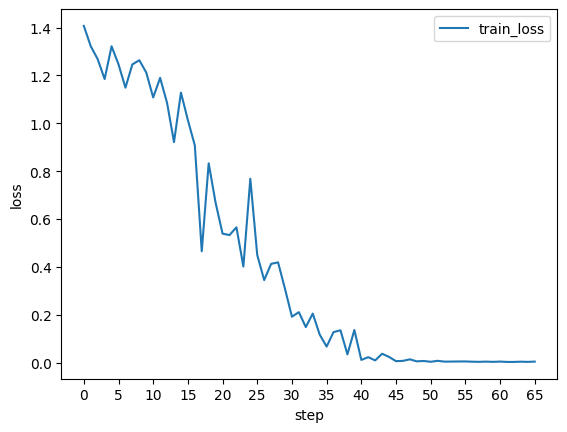

In [26]:
plot_loss(train_loss)

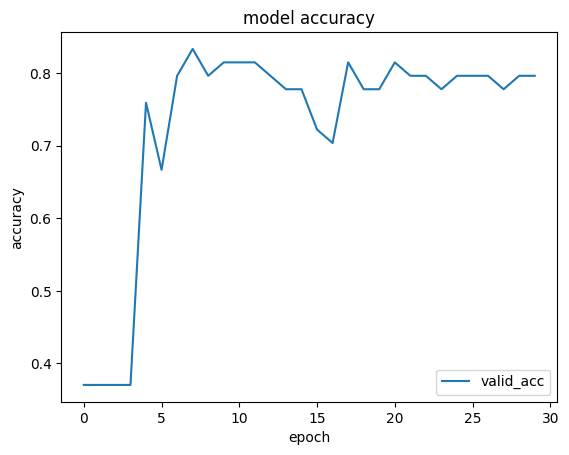

In [27]:
plot_metrics(eval_acc)

In [28]:
base_folder = CFG.MODEL_SAVE_PATH / 'n'
trained_model_path = [f for f in base_folder.iterdir() if f.is_dir() and "checkpoint-" in f.name][0]
trained_model = AutoModelForSequenceClassification.from_pretrained(trained_model_path)

In [29]:
trainer = Trainer(
    model=trained_model,
    args=training_args,
    train_dataset=train_dataset_n,
    eval_dataset=val_dataset_n,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

predictions = torch.softmax(torch.tensor(trainer.predict(val_dataset_n).predictions), dim = 1).argmax(axis=1).tolist()
labels = [val_dataset_n[i]["labels"].item() for i in range(len(val_dataset_n))]
print(accuracy_score(labels, predictions))


  0%|          | 0/11 [00:00<?, ?it/s]

0.8333333333333334


# M分類の学習

In [30]:
training_args = TrainingArguments(
    do_eval=True,
    evaluation_strategy="epoch",
    learning_rate=CFG.LEARNING_RATE,
    lr_scheduler_type='linear',
    per_device_train_batch_size=CFG.BATCH_SIZE,
    per_device_eval_batch_size=CFG.BATCH_SIZE,
    gradient_accumulation_steps=1, # 勾配の累積ステップ数。メモリ不足の場合は増やす。
    num_train_epochs=CFG.EPOCHS,
    weight_decay=0.01, # 正則化
    fp16=False, # 高速化. NVIDIA GPUのみ
    logging_dir= Path('./logs_m'),
    logging_steps=CFG.STEPS,
    save_strategy="epoch",
    output_dir=CFG.MODEL_SAVE_PATH / 'm',
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model=CFG.METRIC,
    greater_is_better=True,
    save_safetensors=True, # モデルの保存形式
    push_to_hub=False,
    seed=CFG.SEED,
    data_seed=CFG.SEED,
)

In [31]:
config = AutoConfig.from_pretrained(CFG.MODEL_PATH)
config.num_labels=CFG.TARGET_CLASS_NUM3
model = AutoModelForSequenceClassification.from_pretrained(CFG.MODEL_PATH, config=config)
model.classifier

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1024, out_features=4, bias=True)

In [32]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_m,
    eval_dataset=val_dataset_m,
    data_collator=DataCollatorWithPadding(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/660 [00:00<?, ?it/s]

{'loss': 1.4298, 'grad_norm': 7.23427152633667, 'learning_rate': 9.84848484848485e-06, 'epoch': 0.45}
{'loss': 1.1594, 'grad_norm': 9.75963020324707, 'learning_rate': 9.696969696969698e-06, 'epoch': 0.91}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.3487083911895752, 'eval_accuracy': 0.5, 'eval_f1': 0.3333333333333333, 'eval_precision': 0.25, 'eval_recall': 0.5, 'eval_runtime': 1.4843, 'eval_samples_per_second': 36.38, 'eval_steps_per_second': 7.411, 'epoch': 1.0}
{'loss': 0.9079, 'grad_norm': 13.641755104064941, 'learning_rate': 9.545454545454547e-06, 'epoch': 1.36}
{'loss': 0.9638, 'grad_norm': 22.015104293823242, 'learning_rate': 9.393939393939396e-06, 'epoch': 1.82}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.296554446220398, 'eval_accuracy': 0.5, 'eval_f1': 0.3333333333333333, 'eval_precision': 0.25, 'eval_recall': 0.5, 'eval_runtime': 1.5, 'eval_samples_per_second': 36.001, 'eval_steps_per_second': 7.334, 'epoch': 2.0}
{'loss': 1.0811, 'grad_norm': 9.323822021484375, 'learning_rate': 9.242424242424244e-06, 'epoch': 2.27}
{'loss': 0.7957, 'grad_norm': 6.638225555419922, 'learning_rate': 9.090909090909091e-06, 'epoch': 2.73}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.7065539360046387, 'eval_accuracy': 0.5, 'eval_f1': 0.3333333333333333, 'eval_precision': 0.25, 'eval_recall': 0.5, 'eval_runtime': 1.5253, 'eval_samples_per_second': 35.402, 'eval_steps_per_second': 7.212, 'epoch': 3.0}
{'loss': 0.7545, 'grad_norm': 9.152896881103516, 'learning_rate': 8.93939393939394e-06, 'epoch': 3.18}
{'loss': 0.7836, 'grad_norm': 6.065872669219971, 'learning_rate': 8.787878787878788e-06, 'epoch': 3.64}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.3651785850524902, 'eval_accuracy': 0.5, 'eval_f1': 0.3333333333333333, 'eval_precision': 0.25, 'eval_recall': 0.5, 'eval_runtime': 1.5243, 'eval_samples_per_second': 35.425, 'eval_steps_per_second': 7.216, 'epoch': 4.0}
{'loss': 0.8651, 'grad_norm': 9.671541213989258, 'learning_rate': 8.636363636363637e-06, 'epoch': 4.09}
{'loss': 0.7108, 'grad_norm': 6.792470455169678, 'learning_rate': 8.484848484848486e-06, 'epoch': 4.55}
{'loss': 0.63, 'grad_norm': 14.378096580505371, 'learning_rate': 8.333333333333334e-06, 'epoch': 5.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.23910653591156, 'eval_accuracy': 0.6851851851851852, 'eval_f1': 0.6155993431855501, 'eval_precision': 0.616983791402396, 'eval_recall': 0.6851851851851852, 'eval_runtime': 1.4843, 'eval_samples_per_second': 36.38, 'eval_steps_per_second': 7.411, 'epoch': 5.0}
{'loss': 0.6013, 'grad_norm': 9.426726341247559, 'learning_rate': 8.181818181818183e-06, 'epoch': 5.45}
{'loss': 0.4981, 'grad_norm': 9.481013298034668, 'learning_rate': 8.03030303030303e-06, 'epoch': 5.91}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.562841534614563, 'eval_accuracy': 0.6851851851851852, 'eval_f1': 0.6155993431855501, 'eval_precision': 0.616983791402396, 'eval_recall': 0.6851851851851852, 'eval_runtime': 1.5393, 'eval_samples_per_second': 35.08, 'eval_steps_per_second': 7.146, 'epoch': 6.0}
{'loss': 0.4579, 'grad_norm': 2.891432762145996, 'learning_rate': 7.87878787878788e-06, 'epoch': 6.36}
{'loss': 0.4799, 'grad_norm': 0.8321923613548279, 'learning_rate': 7.727272727272727e-06, 'epoch': 6.82}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.2760406732559204, 'eval_accuracy': 0.7222222222222222, 'eval_f1': 0.6575757575757576, 'eval_precision': 0.6108058608058607, 'eval_recall': 0.7222222222222222, 'eval_runtime': 1.5443, 'eval_samples_per_second': 34.966, 'eval_steps_per_second': 7.123, 'epoch': 7.0}
{'loss': 0.484, 'grad_norm': 11.243804931640625, 'learning_rate': 7.5757575757575764e-06, 'epoch': 7.27}
{'loss': 0.3319, 'grad_norm': 2.8348684310913086, 'learning_rate': 7.424242424242425e-06, 'epoch': 7.73}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.7941241264343262, 'eval_accuracy': 0.7037037037037037, 'eval_f1': 0.6558586378452566, 'eval_precision': 0.6708333333333334, 'eval_recall': 0.7037037037037037, 'eval_runtime': 1.5413, 'eval_samples_per_second': 35.034, 'eval_steps_per_second': 7.137, 'epoch': 8.0}
{'loss': 0.4097, 'grad_norm': 10.108262062072754, 'learning_rate': 7.272727272727273e-06, 'epoch': 8.18}
{'loss': 0.6551, 'grad_norm': 15.472006797790527, 'learning_rate': 7.121212121212122e-06, 'epoch': 8.64}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.3187572956085205, 'eval_accuracy': 0.5185185185185185, 'eval_f1': 0.3950877192982456, 'eval_precision': 0.6145833333333334, 'eval_recall': 0.5185185185185185, 'eval_runtime': 1.5393, 'eval_samples_per_second': 35.08, 'eval_steps_per_second': 7.146, 'epoch': 9.0}
{'loss': 0.5018, 'grad_norm': 9.083078384399414, 'learning_rate': 6.969696969696971e-06, 'epoch': 9.09}
{'loss': 0.2679, 'grad_norm': 1.484538197517395, 'learning_rate': 6.818181818181818e-06, 'epoch': 9.55}
{'loss': 0.8182, 'grad_norm': 21.42050552368164, 'learning_rate': 6.666666666666667e-06, 'epoch': 10.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.003587007522583, 'eval_accuracy': 0.6481481481481481, 'eval_f1': 0.5749912188268352, 'eval_precision': 0.6268115942028986, 'eval_recall': 0.6481481481481481, 'eval_runtime': 1.4743, 'eval_samples_per_second': 36.627, 'eval_steps_per_second': 7.461, 'epoch': 10.0}
{'loss': 0.3924, 'grad_norm': 24.33285140991211, 'learning_rate': 6.515151515151516e-06, 'epoch': 10.45}
{'loss': 0.3166, 'grad_norm': 8.187679290771484, 'learning_rate': 6.363636363636364e-06, 'epoch': 10.91}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.847686529159546, 'eval_accuracy': 0.5925925925925926, 'eval_f1': 0.5712820512820513, 'eval_precision': 0.662280701754386, 'eval_recall': 0.5925925925925926, 'eval_runtime': 1.5123, 'eval_samples_per_second': 35.706, 'eval_steps_per_second': 7.273, 'epoch': 11.0}
{'loss': 0.1453, 'grad_norm': 13.698424339294434, 'learning_rate': 6.212121212121213e-06, 'epoch': 11.36}
{'loss': 0.5543, 'grad_norm': 49.50631332397461, 'learning_rate': 6.060606060606061e-06, 'epoch': 11.82}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.4516911506652832, 'eval_accuracy': 0.6481481481481481, 'eval_f1': 0.6481481481481481, 'eval_precision': 0.6481481481481481, 'eval_recall': 0.6481481481481481, 'eval_runtime': 1.5503, 'eval_samples_per_second': 34.831, 'eval_steps_per_second': 7.095, 'epoch': 12.0}
{'loss': 0.1867, 'grad_norm': 0.1710401475429535, 'learning_rate': 5.90909090909091e-06, 'epoch': 12.27}
{'loss': 0.097, 'grad_norm': 0.19958490133285522, 'learning_rate': 5.7575757575757586e-06, 'epoch': 12.73}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.9436959028244019, 'eval_accuracy': 0.5370370370370371, 'eval_f1': 0.5320243104254324, 'eval_precision': 0.6761904761904763, 'eval_recall': 0.5370370370370371, 'eval_runtime': 1.5353, 'eval_samples_per_second': 35.171, 'eval_steps_per_second': 7.165, 'epoch': 13.0}
{'loss': 0.1395, 'grad_norm': 7.245363712310791, 'learning_rate': 5.606060606060606e-06, 'epoch': 13.18}
{'loss': 0.0595, 'grad_norm': 0.9557058215141296, 'learning_rate': 5.4545454545454545e-06, 'epoch': 13.64}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.9569587707519531, 'eval_accuracy': 0.6111111111111112, 'eval_f1': 0.6222222222222222, 'eval_precision': 0.696969696969697, 'eval_recall': 0.6111111111111112, 'eval_runtime': 1.5409, 'eval_samples_per_second': 35.044, 'eval_steps_per_second': 7.139, 'epoch': 14.0}
{'loss': 0.0537, 'grad_norm': 0.7316195964813232, 'learning_rate': 5.303030303030303e-06, 'epoch': 14.09}
{'loss': 0.0182, 'grad_norm': 1.1258946657180786, 'learning_rate': 5.151515151515152e-06, 'epoch': 14.55}
{'loss': 0.0173, 'grad_norm': 0.1342908889055252, 'learning_rate': 5e-06, 'epoch': 15.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.32411527633667, 'eval_accuracy': 0.5555555555555556, 'eval_f1': 0.5910931174089069, 'eval_precision': 0.7, 'eval_recall': 0.5555555555555556, 'eval_runtime': 1.4923, 'eval_samples_per_second': 36.185, 'eval_steps_per_second': 7.371, 'epoch': 15.0}
{'loss': 0.1178, 'grad_norm': 0.8712812662124634, 'learning_rate': 4.848484848484849e-06, 'epoch': 15.45}
{'loss': 0.0531, 'grad_norm': 7.034125804901123, 'learning_rate': 4.696969696969698e-06, 'epoch': 15.91}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.4251673221588135, 'eval_accuracy': 0.5925925925925926, 'eval_f1': 0.6187739463601533, 'eval_precision': 0.7043010752688171, 'eval_recall': 0.5925925925925926, 'eval_runtime': 1.5273, 'eval_samples_per_second': 35.356, 'eval_steps_per_second': 7.202, 'epoch': 16.0}
{'loss': 0.074, 'grad_norm': 2.489351511001587, 'learning_rate': 4.5454545454545455e-06, 'epoch': 16.36}
{'loss': 0.0055, 'grad_norm': 0.12654940783977509, 'learning_rate': 4.393939393939394e-06, 'epoch': 16.82}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.670466423034668, 'eval_accuracy': 0.5740740740740741, 'eval_f1': 0.573763440860215, 'eval_precision': 0.6761904761904763, 'eval_recall': 0.5740740740740741, 'eval_runtime': 1.5273, 'eval_samples_per_second': 35.356, 'eval_steps_per_second': 7.202, 'epoch': 17.0}
{'loss': 0.056, 'grad_norm': 0.05083031207323074, 'learning_rate': 4.242424242424243e-06, 'epoch': 17.27}
{'loss': 0.0901, 'grad_norm': 29.84967041015625, 'learning_rate': 4.0909090909090915e-06, 'epoch': 17.73}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.011416435241699, 'eval_accuracy': 0.5185185185185185, 'eval_f1': 0.5414792603698151, 'eval_precision': 0.7043010752688171, 'eval_recall': 0.5185185185185185, 'eval_runtime': 1.5316, 'eval_samples_per_second': 35.258, 'eval_steps_per_second': 7.182, 'epoch': 18.0}
{'loss': 0.0607, 'grad_norm': 0.0867641270160675, 'learning_rate': 3.93939393939394e-06, 'epoch': 18.18}
{'loss': 0.023, 'grad_norm': 0.109693244099617, 'learning_rate': 3.7878787878787882e-06, 'epoch': 18.64}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.220132350921631, 'eval_accuracy': 0.5370370370370371, 'eval_f1': 0.5320243104254324, 'eval_precision': 0.6761904761904763, 'eval_recall': 0.5370370370370371, 'eval_runtime': 1.5423, 'eval_samples_per_second': 35.012, 'eval_steps_per_second': 7.132, 'epoch': 19.0}
{'loss': 0.0041, 'grad_norm': 0.11581949144601822, 'learning_rate': 3.6363636363636366e-06, 'epoch': 19.09}
{'loss': 0.0034, 'grad_norm': 0.08537400513887405, 'learning_rate': 3.4848484848484854e-06, 'epoch': 19.55}
{'loss': 0.0056, 'grad_norm': 0.14681082963943481, 'learning_rate': 3.3333333333333333e-06, 'epoch': 20.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.933173894882202, 'eval_accuracy': 0.5555555555555556, 'eval_f1': 0.5637158469945356, 'eval_precision': 0.6715686274509804, 'eval_recall': 0.5555555555555556, 'eval_runtime': 1.4733, 'eval_samples_per_second': 36.652, 'eval_steps_per_second': 7.466, 'epoch': 20.0}
{'loss': 0.0036, 'grad_norm': 0.09654935449361801, 'learning_rate': 3.181818181818182e-06, 'epoch': 20.45}
{'loss': 0.0023, 'grad_norm': 0.06083056703209877, 'learning_rate': 3.0303030303030305e-06, 'epoch': 20.91}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.8889713287353516, 'eval_accuracy': 0.5555555555555556, 'eval_f1': 0.5700000000000001, 'eval_precision': 0.6818181818181819, 'eval_recall': 0.5555555555555556, 'eval_runtime': 1.5379, 'eval_samples_per_second': 35.114, 'eval_steps_per_second': 7.153, 'epoch': 21.0}
{'loss': 0.0027, 'grad_norm': 0.1088256910443306, 'learning_rate': 2.8787878787878793e-06, 'epoch': 21.36}
{'loss': 0.0029, 'grad_norm': 0.2274170070886612, 'learning_rate': 2.7272727272727272e-06, 'epoch': 21.82}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.1101837158203125, 'eval_accuracy': 0.5370370370370371, 'eval_f1': 0.5437158469945355, 'eval_precision': 0.6715686274509804, 'eval_recall': 0.5370370370370371, 'eval_runtime': 1.5343, 'eval_samples_per_second': 35.194, 'eval_steps_per_second': 7.169, 'epoch': 22.0}
{'loss': 0.0027, 'grad_norm': 0.07067816704511642, 'learning_rate': 2.575757575757576e-06, 'epoch': 22.27}
{'loss': 0.0023, 'grad_norm': 0.06542075425386429, 'learning_rate': 2.4242424242424244e-06, 'epoch': 22.73}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.161884069442749, 'eval_accuracy': 0.5555555555555556, 'eval_f1': 0.553763440860215, 'eval_precision': 0.6761904761904763, 'eval_recall': 0.5555555555555556, 'eval_runtime': 1.5363, 'eval_samples_per_second': 35.148, 'eval_steps_per_second': 7.16, 'epoch': 23.0}
{'loss': 0.002, 'grad_norm': 0.03867858648300171, 'learning_rate': 2.2727272727272728e-06, 'epoch': 23.18}
{'loss': 0.0025, 'grad_norm': 0.09474450349807739, 'learning_rate': 2.1212121212121216e-06, 'epoch': 23.64}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.1943435668945312, 'eval_accuracy': 0.5370370370370371, 'eval_f1': 0.5437158469945355, 'eval_precision': 0.6715686274509804, 'eval_recall': 0.5370370370370371, 'eval_runtime': 1.5263, 'eval_samples_per_second': 35.379, 'eval_steps_per_second': 7.207, 'epoch': 24.0}
{'loss': 0.0025, 'grad_norm': 0.06549438089132309, 'learning_rate': 1.96969696969697e-06, 'epoch': 24.09}
{'loss': 0.0023, 'grad_norm': 0.05355939641594887, 'learning_rate': 1.8181818181818183e-06, 'epoch': 24.55}
{'loss': 0.0017, 'grad_norm': 0.029534032568335533, 'learning_rate': 1.6666666666666667e-06, 'epoch': 25.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.2169370651245117, 'eval_accuracy': 0.5370370370370371, 'eval_f1': 0.5437158469945355, 'eval_precision': 0.6715686274509804, 'eval_recall': 0.5370370370370371, 'eval_runtime': 1.4753, 'eval_samples_per_second': 36.602, 'eval_steps_per_second': 7.456, 'epoch': 25.0}
{'loss': 0.0016, 'grad_norm': 0.07800500094890594, 'learning_rate': 1.5151515151515152e-06, 'epoch': 25.45}
{'loss': 0.0023, 'grad_norm': 0.09904816746711731, 'learning_rate': 1.3636363636363636e-06, 'epoch': 25.91}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.2171032428741455, 'eval_accuracy': 0.5370370370370371, 'eval_f1': 0.5437158469945355, 'eval_precision': 0.6715686274509804, 'eval_recall': 0.5370370370370371, 'eval_runtime': 1.5493, 'eval_samples_per_second': 34.854, 'eval_steps_per_second': 7.1, 'epoch': 26.0}
{'loss': 0.0016, 'grad_norm': 0.03237658366560936, 'learning_rate': 1.2121212121212122e-06, 'epoch': 26.36}
{'loss': 0.0019, 'grad_norm': 0.05177640914916992, 'learning_rate': 1.0606060606060608e-06, 'epoch': 26.82}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.232475519180298, 'eval_accuracy': 0.5370370370370371, 'eval_f1': 0.5437158469945355, 'eval_precision': 0.6715686274509804, 'eval_recall': 0.5370370370370371, 'eval_runtime': 1.5583, 'eval_samples_per_second': 34.652, 'eval_steps_per_second': 7.059, 'epoch': 27.0}
{'loss': 0.0019, 'grad_norm': 0.07958836108446121, 'learning_rate': 9.090909090909091e-07, 'epoch': 27.27}
{'loss': 0.0017, 'grad_norm': 0.026279209181666374, 'learning_rate': 7.575757575757576e-07, 'epoch': 27.73}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.2475292682647705, 'eval_accuracy': 0.5370370370370371, 'eval_f1': 0.5437158469945355, 'eval_precision': 0.6715686274509804, 'eval_recall': 0.5370370370370371, 'eval_runtime': 1.5503, 'eval_samples_per_second': 34.831, 'eval_steps_per_second': 7.095, 'epoch': 28.0}
{'loss': 0.0018, 'grad_norm': 0.03656887635588646, 'learning_rate': 6.060606060606061e-07, 'epoch': 28.18}
{'loss': 0.0017, 'grad_norm': 0.07307109236717224, 'learning_rate': 4.5454545454545457e-07, 'epoch': 28.64}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.258423089981079, 'eval_accuracy': 0.5370370370370371, 'eval_f1': 0.5437158469945355, 'eval_precision': 0.6715686274509804, 'eval_recall': 0.5370370370370371, 'eval_runtime': 1.5483, 'eval_samples_per_second': 34.876, 'eval_steps_per_second': 7.104, 'epoch': 29.0}
{'loss': 0.0016, 'grad_norm': 0.0348217748105526, 'learning_rate': 3.0303030303030305e-07, 'epoch': 29.09}
{'loss': 0.0016, 'grad_norm': 0.06345448642969131, 'learning_rate': 1.5151515151515152e-07, 'epoch': 29.55}
{'loss': 0.0026, 'grad_norm': 0.24227121472358704, 'learning_rate': 0.0, 'epoch': 30.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.2590527534484863, 'eval_accuracy': 0.5370370370370371, 'eval_f1': 0.5437158469945355, 'eval_precision': 0.6715686274509804, 'eval_recall': 0.5370370370370371, 'eval_runtime': 1.6773, 'eval_samples_per_second': 32.195, 'eval_steps_per_second': 6.558, 'epoch': 30.0}
{'train_runtime': 542.9083, 'train_samples_per_second': 5.968, 'train_steps_per_second': 1.216, 'train_loss': 0.27438047409734945, 'epoch': 30.0}


TrainOutput(global_step=660, training_loss=0.27438047409734945, metrics={'train_runtime': 542.9083, 'train_samples_per_second': 5.968, 'train_steps_per_second': 1.216, 'total_flos': 1693546024221312.0, 'train_loss': 0.27438047409734945, 'epoch': 30.0})

In [33]:
train_loss, eval_acc = [],[]

for log in trainer.state.log_history:
    if 'loss' in log:
         train_loss.append(log['loss'])
    if 'eval_accuracy' in log:
        eval_acc.append(log['eval_accuracy'])


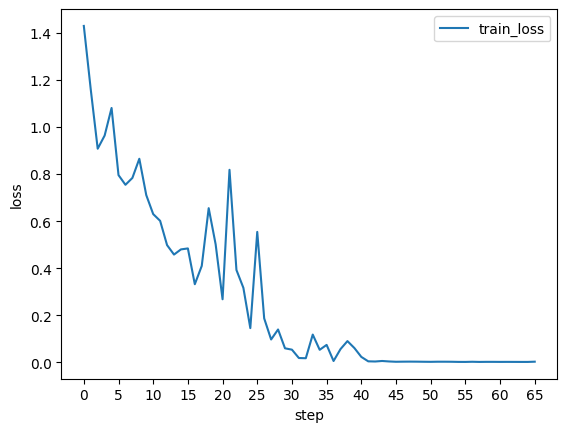

In [34]:
plot_loss(train_loss)

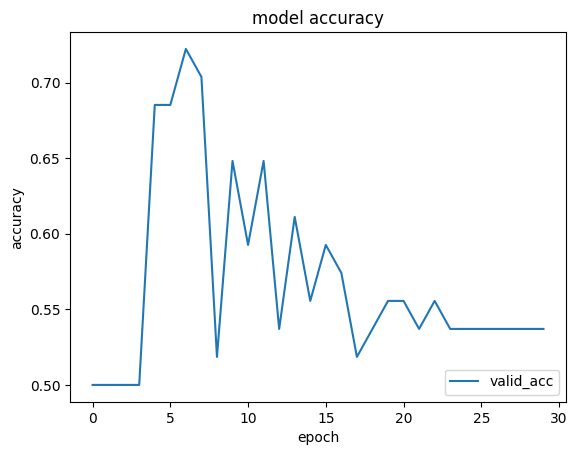

In [35]:
plot_metrics(eval_acc)

In [36]:
base_folder = CFG.MODEL_SAVE_PATH / 'm'
trained_model_path = [f for f in base_folder.iterdir() if f.is_dir() and "checkpoint-" in f.name][0]
trained_model = AutoModelForSequenceClassification.from_pretrained(trained_model_path)

In [37]:
trainer = Trainer(
    model=trained_model,
    args=training_args,
    train_dataset=train_dataset_m,
    eval_dataset=val_dataset_m,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

predictions = torch.softmax(torch.tensor(trainer.predict(val_dataset_m).predictions), dim = 1).argmax(axis=1).tolist()
labels = [val_dataset_m[i]["labels"].item() for i in range(len(val_dataset_m))]
print(accuracy_score(labels, predictions))


  0%|          | 0/11 [00:00<?, ?it/s]

0.7222222222222222
